# Stochastic SIR model analysis using pyABC

In [1]:
!which python

/home/yannik/miniconda3/envs/env/bin/python


In [2]:
#pip install --upgrade pyabc

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyabc

## Define model and data

In [4]:
low_beta = 0.01 
high_beta = 1. 
low_gamma = 0.
high_gamma = 1.

#def prior(batch_size):
#    """
#    Samples from the prior 'batch_size' times.
#    ----------
#    Output:
#    theta : np.ndarray of shape (batch_size, theta_dim) 
#    """    
    # Prior range for rate parameters: 
#    beta_samples = np.random.uniform(low=low_beta, high=high_beta, size=batch_size)
#    gamma_samples = np.random.uniform(low=low_gamma, high=beta_samples)
#    p_samples = np.c_[beta_samples, gamma_samples]
#    return p_samples.astype(np.float32)

In [5]:
N = 1000   # population size
u0 = [N-1,1,0]   # initial state  
iota = 0.5 
dt = 0.1   # time step
n_dt = 500   # number of simulation time steps
t_end = n_dt * dt
n_obs = 21   # number of observations
time_points = np.linspace(0, t_end, n_obs)

def simulate_sir(beta, gamma, present_indices):
    """Simulates a single SIR process at specified time points."""
    #gamma *= beta   # this transformation is done to obtain the prescribed hierarchical prior
    
    def sir_equation(u):
        """Implements the stochastic SIR equations."""
        S, I, R = u
        lambd = beta *(I+iota)/N
        ifrac = 1.0 - np.exp(-lambd*dt)
        rfrac = 1.0 - np.exp(-gamma*dt)
        infection = np.random.binomial(S, ifrac)
        recovery = np.random.binomial(I, rfrac)
        return [S-infection, I+infection-recovery, R+recovery]
    
    S = np.zeros(n_obs)
    I = np.zeros(n_obs)
    R = np.zeros(n_obs)
    u = u0
    S[0], I[0], R[0] = u
    
    for j in range(1, n_dt+1):
        u = sir_equation(u)
        if j % 25 == 0:
            i = j//25
            S[i], I[i], R[i] = u
        
    return (np.array([S, I, R]).T/N)[present_indices]

In [6]:
# Load test data
prior_samples = np.array([[0.72, 0.41], [0.45, 0.23], [0.26, 0.07], [0.87, 0.05], [0.15, 0.14]])
x_datas = np.load("x_datas.npy")

In [7]:
# Postprocess test data 
data_sets = []
present_indices_list = []

for x_data in x_datas:
    bin_ind = x_data[:,3]
    present_indices = np.where(bin_ind == 1.)[0]
    data_set = x_data[present_indices, 0:3]
    present_indices_list.append(present_indices)
    data_sets.append(data_set)

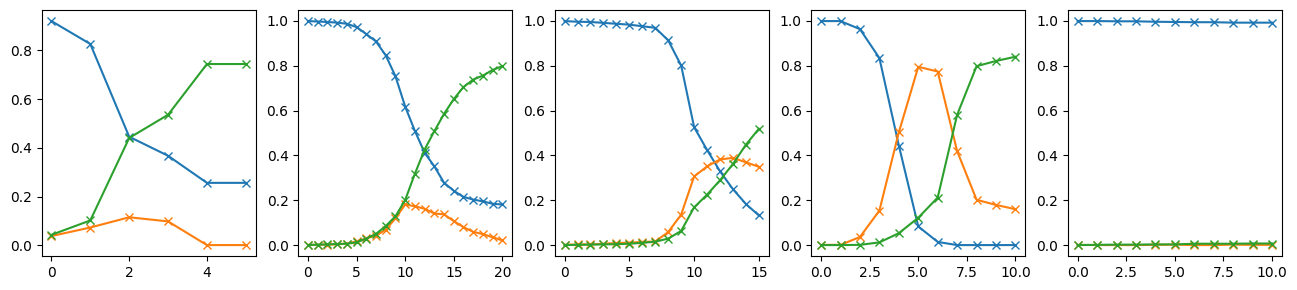

In [8]:
n_sets = len(x_datas)
_, axes = plt.subplots(1, n_sets, figsize=(16, 16 / n_sets))

for data_set, ax in zip(data_sets, axes):
    ax.plot(data_set, 'x-')

## Set up and run pyABC problem

In [9]:
import scipy.stats

gt_pars = [{"β": v[0], "γ": v[1]} for v in prior_samples]

par_limits = {
    "β": (low_beta, high_beta),
    "γ": (low_gamma, high_gamma),
}

#prior_abc = pyabc.Distribution(
#    **{key: pyabc.RV("uniform", l, h-l)
#       for key, (l, h) in par_limits.items()}
#)

class CustomPrior(pyabc.DistributionBase):
    
    def rvs(self, *args, **kwargs):
        rv_beta = scipy.stats.uniform(low_beta, high_beta - low_beta)
        beta = rv_beta.rvs()
        
        rv_gamma = scipy.stats.uniform(low_gamma, beta - low_gamma)
        gamma = rv_gamma.rvs()
        
        return pyabc.Parameter(β=beta, γ=gamma)
    
    def pdf(self, x):
        beta, gamma = x["β"], x["γ"]
        return scipy.stats.uniform(low_beta, high_beta - low_beta).pdf(beta) * scipy.stats.uniform(low_gamma, beta - low_gamma).pdf(gamma)
    
prior_abc = CustomPrior()

distance_abc = pyabc.PNormDistance(p=2)

In [10]:
%%time

pop_size = 1000

hs = []

for ix, data_set in enumerate(data_sets):
    def model_abc(p):
        return {"y": simulate_sir(p["β"], p["γ"], present_indices_list[ix])}
    abc = pyabc.ABCSMC(model_abc, prior_abc, distance_abc, population_size=pop_size)
    abc.new(f"sqlite:///pyabc_history_{ix}.db", observed_sum_stat={"y": data_set})
    h = abc.run(min_acceptance_rate=0.5e-2)
    hs.append(h)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2023-04-02 08:52:21>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.45122385e+00.
ABC INFO: Accepted: 1000 / 1918 = 5.2138e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.05263024e-01.
ABC INFO: Accepted: 1000 / 1994 = 5.0150e-01, ESS: 9.5581e+02.
ABC INFO: t: 2, eps: 6.10284080e-01.
ABC INFO: Accepted: 1000 / 2474 = 4.0420e-01, ESS: 9.0924e+02.
ABC INFO: t: 3, eps: 4.36216938e-01.
ABC INFO: Accepted: 1000 / 3188 = 3.1368e-01, ESS: 9.3504e+02.
ABC INFO: t: 4, eps: 3.05929429e-01.
ABC INFO: Accepted: 1000 / 3902 = 2.5628e-01, ESS: 8.9766e+02.
ABC INFO: t: 5, eps: 2.19121252e-01.
ABC INFO: Accepted: 1000 / 5731 = 1.7449e-01, ESS: 7.9482e+02.
ABC INFO: t: 6, eps: 1.63702397e-01.
ABC INFO: Accepted: 1000 / 8979 = 1.1137e-01, ESS: 7.4803e+02.
ABC INFO: t: 7, eps: 1.29137394e-01.
ABC INFO: Accepted: 1000 / 13444 = 7.4383e-02, ESS: 7.4511e+02.
ABC INFO: t: 8, eps: 1.01864778e-01.


CPU times: user 1min 4s, sys: 7.74 s, total: 1min 12s
Wall time: 58min 19s


## Visualize results

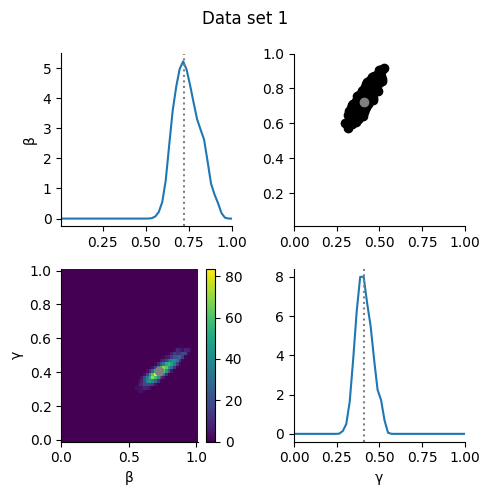

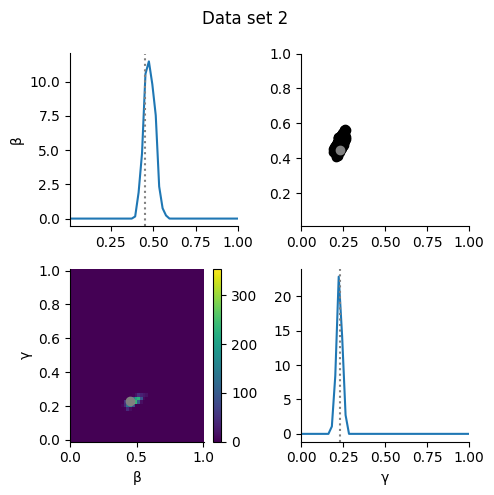

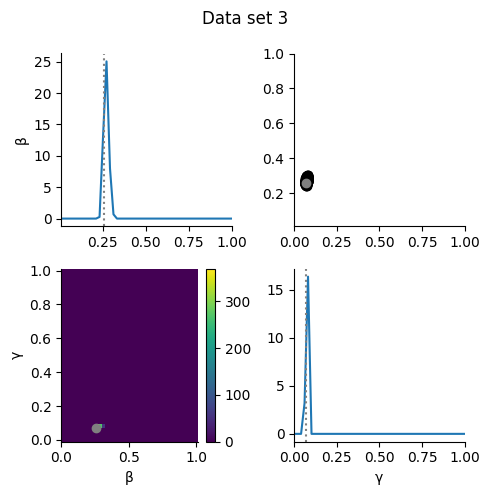

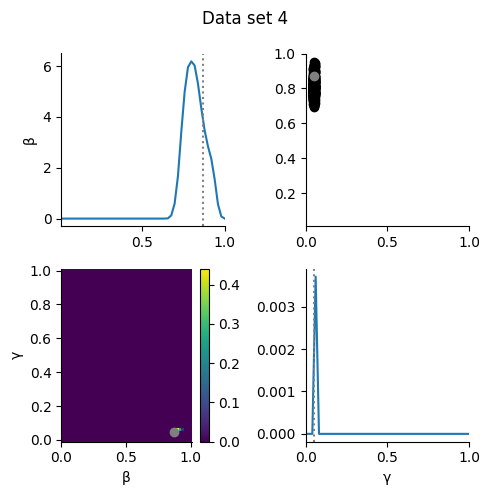

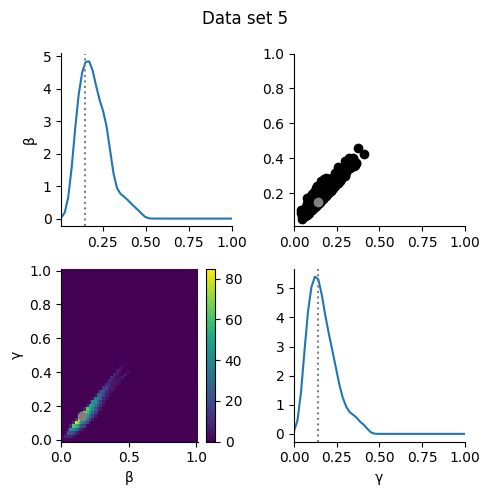

In [11]:
for ix, (gt_par, h) in enumerate(zip(gt_pars, hs)):
    pyabc.visualization.plot_kde_matrix_highlevel(
        h,
        limits=par_limits,
        refval=gt_par,
        refval_color="grey",
    )
    plt.gcf().suptitle(f"Data set {ix+1}")
    plt.gcf().tight_layout();

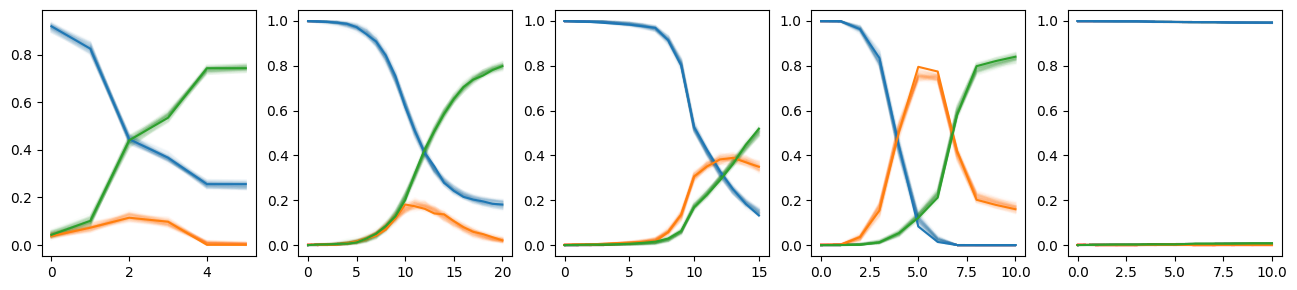

In [12]:
def plot_data(sumstat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    for i in range(3):
        ax.plot(sumstat["y"][:, i], color=f"C{i}", alpha=0.02)


_, axes = plt.subplots(1, n_sets, figsize=(16, 16 / n_sets))

for data_set, h, ax in zip(data_sets, hs, axes):
    pyabc.visualization.plot_data_callback(
        h,
        plot_data,
        ax=ax,
        n_sample=100,
    )
    ax.plot(data_set)

In [13]:
for i, h in enumerate(hs):
    df, w = h.get_distribution()
    np.save(f"pyabc_samples_{i}.npy", df.to_numpy())
    np.save(f"pyabc_weights_{i}.npy", w)